In [1]:
import numpy as np
from stats import LinearSolveStats, TimeStepStats
from stats import TimeStepStats
from matplotlib import pyplot as plt
from plot_utils import *

data = load_data("../stats/fpm_0_open_solver_1.json")

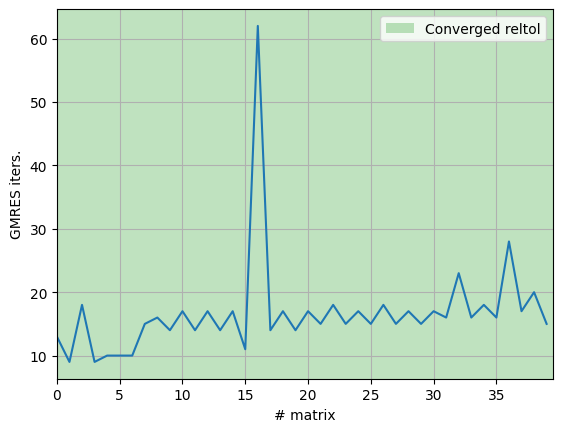

In [2]:
# %matplotlib ipympl
color_converged_reason(data)
plt.plot(get_gmres_iterations(data))
plt.ylabel('GMRES iters.')
plt.xlabel('# matrix')
# plt.yscale('log')
plt.legend()

In [3]:
mat_idx = 14
get_gmres_iterations(data)[mat_idx]

17

In [4]:
from plot_utils import *

mat, rhs = load_matrix_rhs(data, mat_idx)

In [5]:
sticking, sliding, open = get_num_sticking_sliding_open(data)
print(f'{sticking[mat_idx] = }')
print(f'{sliding[mat_idx] = }')
print(f'{open[mat_idx] = }')

sticking[mat_idx] = 12
sliding[mat_idx] = 0
open[mat_idx] = 2


In [6]:
import porepy as pp
import numpy as np
from mat_utils import *
from plot_utils import *
from fpm_0 import make_model
from pp_utils import make_row_col_dofs

model = make_model()
model.prepare_simulation()

model.before_nonlinear_loop()
model.before_nonlinear_iteration()

model._initialize_solver()
eq_dofs, var_dofs = make_row_col_dofs(model)

# model.assemble_linear_system()
# mat, rhs = model.linear_system
model.linear_system = mat, rhs
perm_mat, prec_orig = model._prepare_solver()

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


In [7]:
from pp_utils import make_reorder_contact
reorder_contact = make_reorder_contact(model)
mat = mat[reorder_contact]

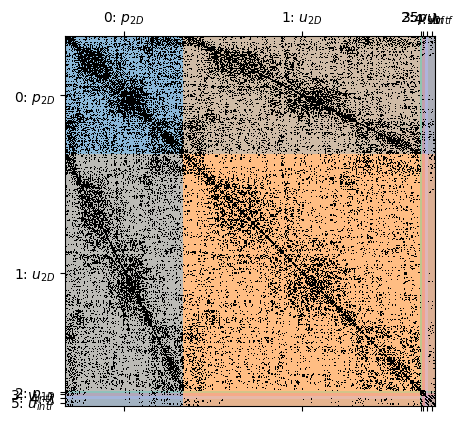

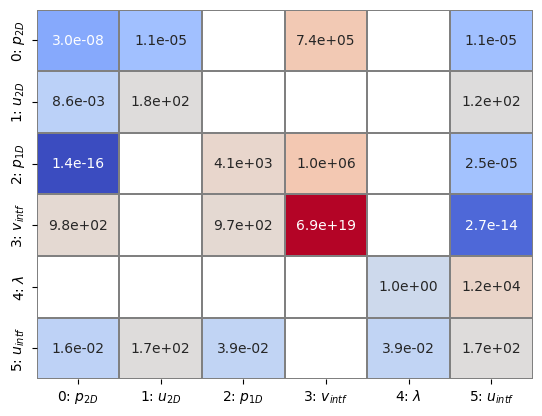

In [8]:
from block_matrix import BlockMatrixStorage

J = BlockMatrixStorage(
    mat=mat,
    row_idx=model.eq_dofs,
    col_idx=model.var_dofs,
    groups_row=model._equation_groups,
    groups_col=model._variable_groups,
    group_row_names=[r'$p_{2D}$', r'$u_{2D}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$'],
    group_col_names=[r'$p_{2D}$', r'$u_{2D}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$']
)
J[:].color_spy(); plt.show()
J[:].plot_max()
# J[:].matshow()

In [86]:
from typing import Literal

def eliminate(mat: BlockMatrixStorage, block_elim, block_keep=None, invertor=None, invertor_type: Literal['algebraic', 'physical'] = 'algebraic') -> BlockMatrixStorage:
    block_elim = [x for x in block_elim if x in mat.active_groups[0]]
    if len(block_elim) == 0:
        print('Skipping')
        return mat
    if block_keep is None:
        block_keep = [x for x in mat.active_groups[0] if x not in block_elim]

    inverted = inv(mat[block_elim].mat)
    stab = mat[block_keep].copy()
    stab.mat = mat[block_keep, block_elim].mat @ inverted @ mat[block_elim, block_keep].mat

    if invertor is not None:
        print('Using approximate invertor')
        stab_approx = mat[block_keep].copy()
        inverted_approx = invertor(mat[block_elim].mat)
        if invertor_type == 'algebraic':
            stab_approx.mat = -mat[block_keep, block_elim].mat @ inverted_approx @ mat[block_elim, block_keep].mat
        else:
            stab_approx.mat = inverted_approx
    else:
        stab_approx = stab

    schur = mat[block_keep].copy()
    schur.mat += stab_approx.mat

    num_subfigures = 3
    if invertor is not None:
        num_subfigures += 1

    plt.figure(figsize=(20, 4))
    plt.subplot(1, num_subfigures, 1)
    plt.title(f'Before elimination: {block_keep}')
    mat[block_keep].plot_max()

    plt.subplot(1, num_subfigures, 2)
    plt.title('After elimination')
    schur.plot_max()

    plt.subplot(1, num_subfigures, 3)
    plt.title('Exact stabilization')
    stab.plot_max()

    if invertor is not None:
        plt.subplot(1, num_subfigures, 4)
        plt.title('Approx stabilization')
        stab_approx.plot_max()
    plt.show()

    try:
        block_keep.remove(0)
    except ValueError:
        pass
    try:
        block_keep.remove(1)
    except ValueError:
        pass

    if len(block_keep) > 0:
        plt.figure(figsize=(20, 4))
        plt.subplot(1, num_subfigures, 1)
        plt.title(f'Before elimination: {block_keep}')
        mat[block_keep].color_spy(show=False)

        plt.subplot(1, num_subfigures, 2)
        plt.title('After elimination')
        schur[block_keep].color_spy(show=False)

        plt.subplot(1, num_subfigures, 3)
        plt.title('Exact stablilzation')
        stab[block_keep].color_spy(show=False)

        if invertor is not None:
            plt.subplot(1, num_subfigures, 4)
            plt.title('Approx stabilization')
            stab_approx[block_keep].color_spy(show=False)
        plt.show()

    return schur

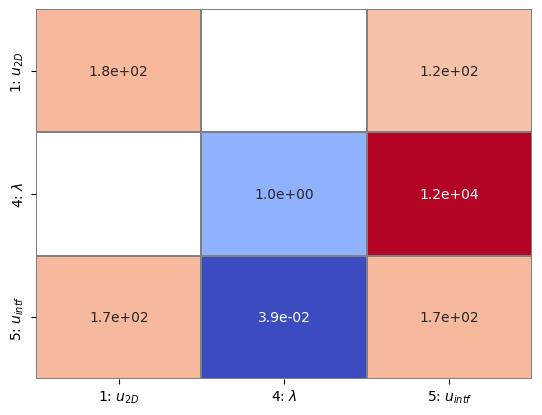

In [87]:
J = J[[1,4,5]]
J.plot_max()

# Eliminating 33

The effect of stabilization:

NOTE: If sticking, COL 5 is empty

In [88]:
J_tmp_3 = eliminate(J, block_elim=[3], invertor=extract_diag_inv)

Skipping


# Eliminating 55

Note: correction is not done in the open cells 

Using approximate invertor


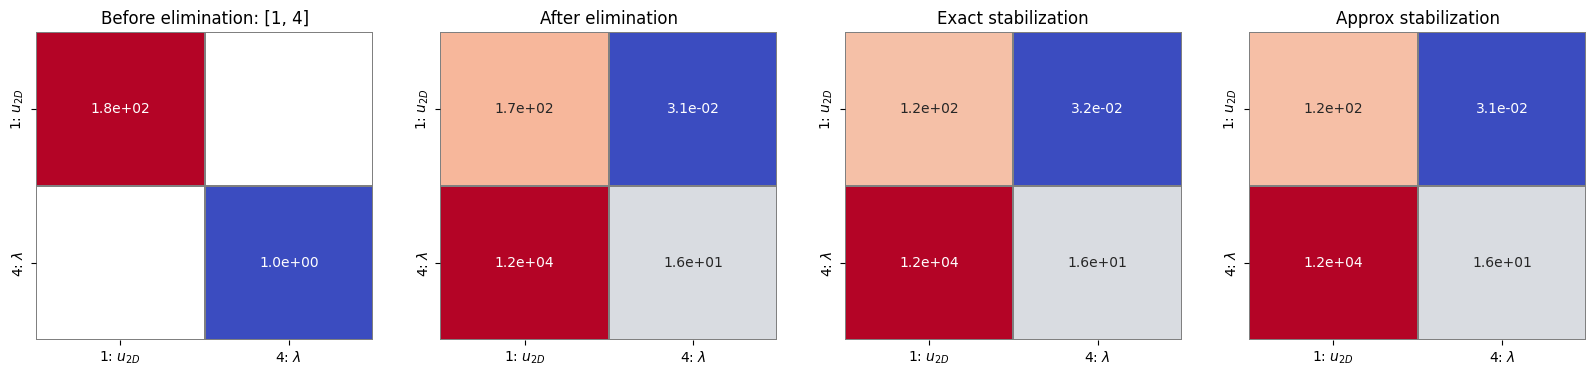

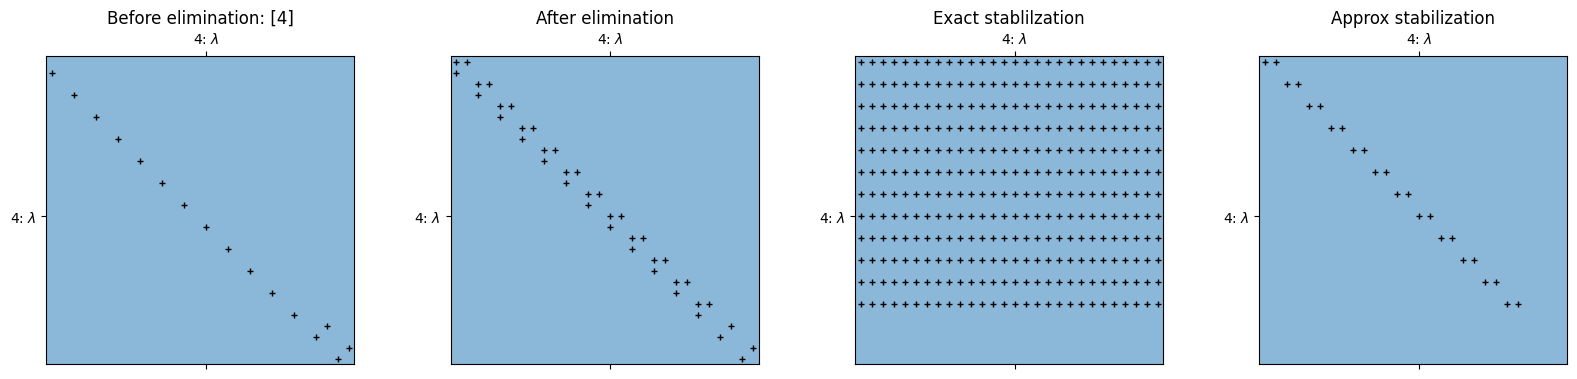

In [95]:
tmp = J_tmp_3
J_tmp_5 = eliminate(tmp, block_elim=[5], invertor=inv_block_diag_2x2)

# Eliminating 44

NOTE: If sticking, ROW 2 is empty

NOTE: If TPFA, COL 2 is empty. If MPFA and sticking, the values of COL 2 are small (1e-17 and 1e-24)

Using approximate invertor


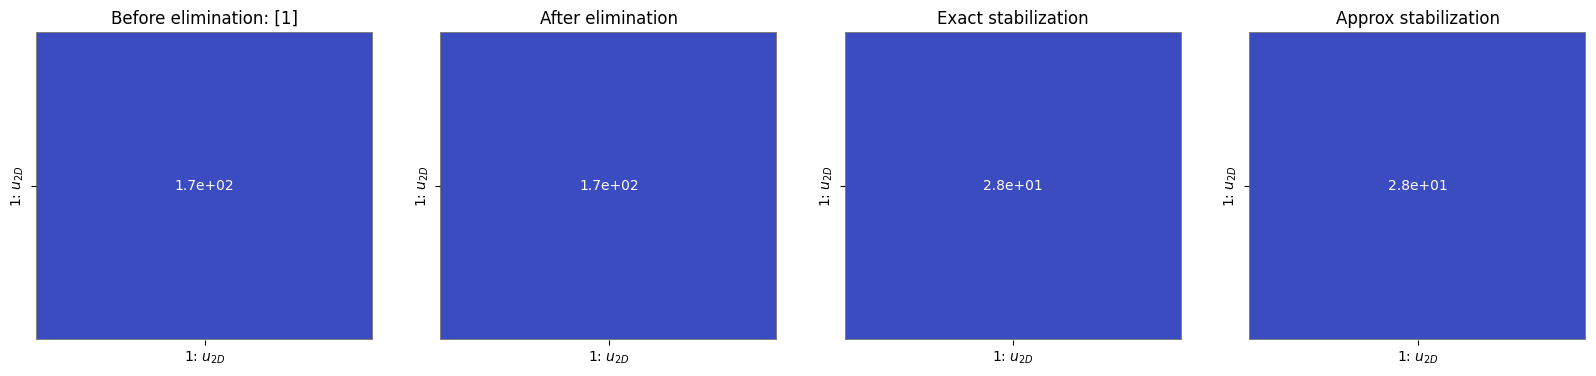

In [96]:
tmp = J_tmp_5
J_tmp_4 = eliminate(tmp, block_elim=[4], invertor=inv_block_diag_2x2)

# Eliminating 11

Note: only open cells are different
Note: After eliminating 11, J22 is symmetric
Note: If all cells are stickimg, no stabilization of J22 is needed

In [94]:
from pp_utils import get_fixed_stress_stabilization_nd
# J_tmp_4 = J_tmp_4
J_tmp_1 = eliminate(J_tmp_4, block_elim=[1], 
                    invertor=lambda _: get_fixed_stress_stabilization_nd(model), invertor_type='physical')

J_tmp_1[[2]].matshow(False)

ValueError: need at least one array to concatenate

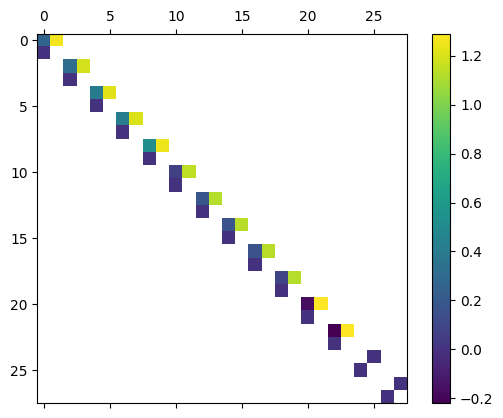

Solve  took: 0.0


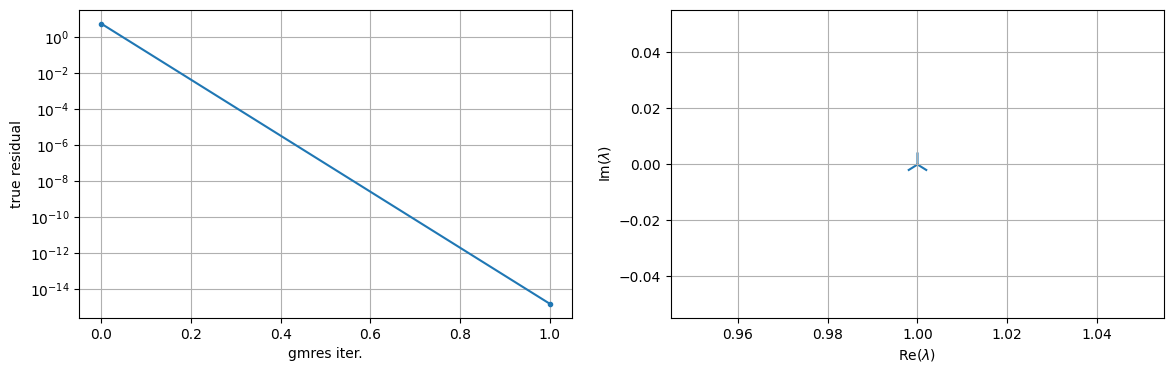

In [20]:
J_tmp_5[[4]].matshow()
tmp = J_tmp_5[[4]].mat
solve_petsc(tmp, inv_block_diag_2x2(tmp))

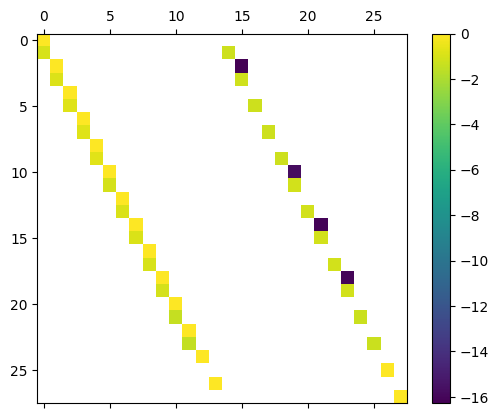

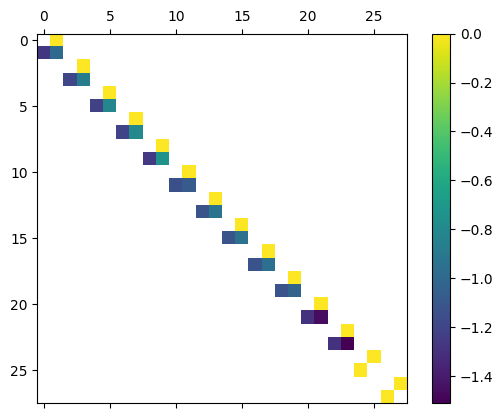

In [40]:
from pp_utils import reorder_J44

reorder = reorder_J44(model)
inv_reorder = np.argsort(reorder)


tmp = J_tmp_5[[4]].mat[inv_reorder]
tmp_inv = inv(tmp)
plot_mat(tmp_inv)

tmp_inv_1 = inv_block_diag_2x2(tmp[reorder])
plot_mat(tmp_inv_1)


# plot_mat(tmp @ tmp_inv)

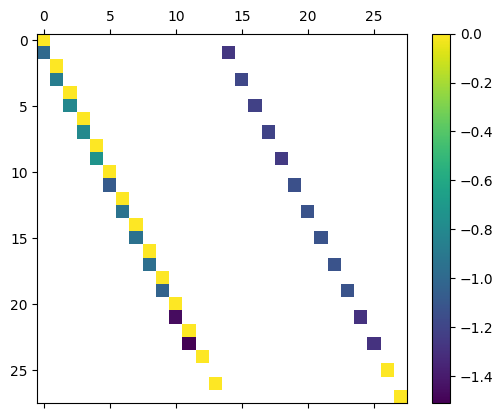

In [55]:
A = tmp
P = scipy.sparse.eye(A.shape[0]).tocsr()
P.indices[:] = reorder
plot_mat(inv_block_diag_2x2(P @ A) @ P)

/home/porepy/simulations/plot_utils.py:90: RuntimeWarning: divide by zero encountered in log10
  mat = np.log10(abs(mat))


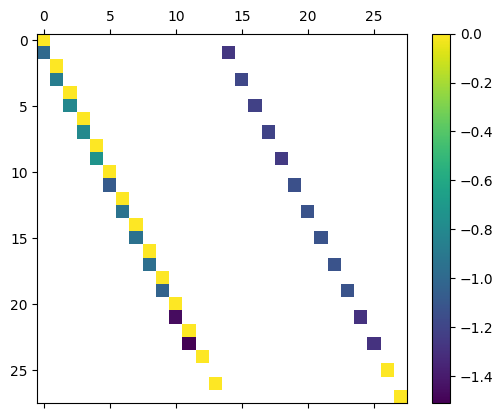

In [59]:
plot_mat(inv_block_diag_2x2(A[reorder])[:, inv_reorder]) 